# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/v5kXkk

Videos:

TA: ntu-ml-2021spring-ta@googlegroups.com

## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [1]:
import torch
import torch.nn as nn
from pytorchcv.model_provider import get_model as ptcv_get_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
num_iter = 20
alpha = 8/num_iter/255/std
mu = .5

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

model_list = [
    'resnet110_cifar10',
    'resnet20_cifar10',
    'resnext29_32x4d_cifar10',
    'resnext272_2x32d_cifar10',
    'pyramidnet110_a48_cifar10',
    'densenet100_k12_cifar10',
    'xdensenet40_2_k24_bc_cifar10',
]

In [2]:
# # test model
# for i, model_name in enumerate(model_list):
#     print(f"< {i+1:02d} / {len(model_list):02d} > ======= {model_name}")
#     model = ptcv_get_model(model_name, pretrained=True)
# del model

## Ensemble Model

In [3]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.n_model = len(models)
        # self.ensemble = nn.Linear(self.n_model*10, 10, bias=False)
        # self.ensemble = nn.Parameter(
        #     torch.ones(self.n_model, 1, 1)/self.n_model
        # )
    
    def forward(self, x):
        out = [m(x) for m in self.models]
        out = torch.stack(out) # Models, B, N
        out = torch.mean(out, 0)
        # out = torch.sum(out*self.ensemble, 0)
        return out

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [4]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [5]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [6]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, grad=0, epsilon=epsilon, mu=mu):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    g_cur = x_adv.grad.detach()
    g = mu*grad + (1-mu) * g_cur / torch.linalg.norm(g_cur.view(g_cur.size(0), -1), ord=1, dim=1).view(-1, 1, 1, 1)
    x_adv = x_adv + epsilon * g.sign()
    return x_adv, g

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter):
    # initialize x_adv as original benign image x
    x_adv = x.detach().clone()
    # write a loop of num_iter to represent the iterative times
    # for each loop
    epsilon = epsilon.flatten()
    grad = 0
    for i in range(num_iter):
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv, grad = fgsm(model, x_adv, y, loss_fn, grad, alpha)
        # clip new x_adv back to [x-epsilon, x+epsilon]
        x_adv = torch.swapaxes(x_adv, 0, 1)
        x_ = torch.swapaxes(x, 0, 1)
        res = []
        for i in range(3):
            res.append(torch.clamp(x_adv[i] - x_[i], -epsilon[i], epsilon[i]))
        res = torch.stack(res)
        res = torch.swapaxes(res, 0, 1)
        x_adv = x + res
    return x_adv

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [7]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in (enumerate(tqdm(loader))):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [8]:
loss_fn = nn.CrossEntropyLoss()
n = len(model_list)
models = [ptcv_get_model(m, pretrained=True).to(device) for m in model_list]
model = EnsembleModel(models)
is_pretrain=True
# if not is_pretrain:
#     model.load_state_dict(torch.load("model.ckpt"))
model = model.to(device)

epoch = 10
optim = torch.optim.AdamW(
    [model.ensemble],
    lr=1e-2, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, 2, gamma=0.5, last_epoch=-1, verbose=False)
n_data = len(adv_loader.dataset)

# Pretrain
if is_pretrain:
    model.eval()
    for e in range(epoch):
        train_acc = 0.0
        train_loss = 0.0
        for x, y in (adv_loader):
            x, y = x.to(device), y.to(device)
            yp = model(x)
            loss = loss_fn(yp, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_acc += (yp.argmax(dim=1) == y).sum().item()
            train_loss += loss.item() * x.shape[0]
        print(f"[{e+1:02d}/{epoch:02d}] {train_acc/n_data:.4f} | {train_loss/n_data:.4f}")
        lr_scheduler.step()
    torch.save(model.state_dict(), "model.ckpt")

## I-FGSM

In [9]:
model.eval()
benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ensemble', adv_examples, adv_names)

benign_acc = 0.97500, benign_loss = 0.10477


  0%|          | 0/25 [00:00<?, ?it/s]

ifgsm_acc = 0.03000, ifgsm_loss = 14.21099


loss_fn = nn.CrossEntropyLoss()
n = len(model_list)
dir_list = os.listdir('result')
for i, model_name in enumerate(model_list):
    print(f"< {i+1:02d} / {n:02d} > ======= {model_name}")
    if model_name in dir_list:
        print("Image existed, skip!")
        continue
    model = ptcv_get_model(model_name, pretrained=True).to(device)
    benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
    print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

    adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
    print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

    create_dir(root, f'result/{model_name}', adv_examples, adv_names)

In [10]:
# f = open('models').readlines()
# ms = []
# for l in f:
#     s = l.split('\'')
#     if len(s) < 2:
#         continue
#     s = s[1]
#     if 'cifar10' in s and 'cifar100' not in s:
#         ms.append(f"\'{s}\',\n")

# f = open('m', 'w')
# f.writelines(ms)
# f.close()

## Ensemble

# Ensemble the created image
adv_datas = [AdvDataset(f'result/{m}', transforms.ToTensor()) for m in model_list]
imgs = []
for i in tqdm(range(len(adv_datas[0]))):
    img = [d[i][0] for d in adv_datas]
    img = torch.mean(torch.stack(img), axis=0)
    img = (img * 255).clamp(0, 255) # 0-255 scale
    img = img.data.numpy().round() # round to remove decimal part
    img = img.transpose((1, 2, 0)) # transpose (C, H, W) back to (H, W, C)
    imgs.append(img)
imgs = np.stack(imgs)
print(imgs.shape)
create_dir(root, 'ensemble', imgs, adv_names)



## Compress the images

In [11]:
%cd ensemble
!tar zcvf ../ensemble.tgz *
%cd ..

/home/csvt32745/ml/hw10/ensemble
airplane/
airplane/airplane16.png
airplane/airplane6.png
airplane/airplane11.png
airplane/airplane10.png
airplane/airplane14.png
airplane/airplane19.png
airplane/airplane7.png
airplane/airplane18.png
airplane/airplane20.png
airplane/airplane4.png
airplane/airplane2.png
airplane/airplane8.png
airplane/airplane3.png
airplane/airplane12.png
airplane/airplane1.png
airplane/airplane5.png
airplane/airplane13.png
airplane/airplane9.png
airplane/airplane17.png
airplane/airplane15.png
automobile/
automobile/automobile8.png
automobile/automobile12.png
automobile/automobile3.png
automobile/automobile9.png
automobile/automobile6.png
automobile/automobile10.png
automobile/automobile18.png
automobile/automobile17.png
automobile/automobile1.png
automobile/automobile14.png
automobile/automobile15.png
automobile/automobile11.png
automobile/automobile4.png
automobile/automobile7.png
automobile/automobile16.png
automobile/automobile19.png
automobile/automobile20.png
autom

## Visualization

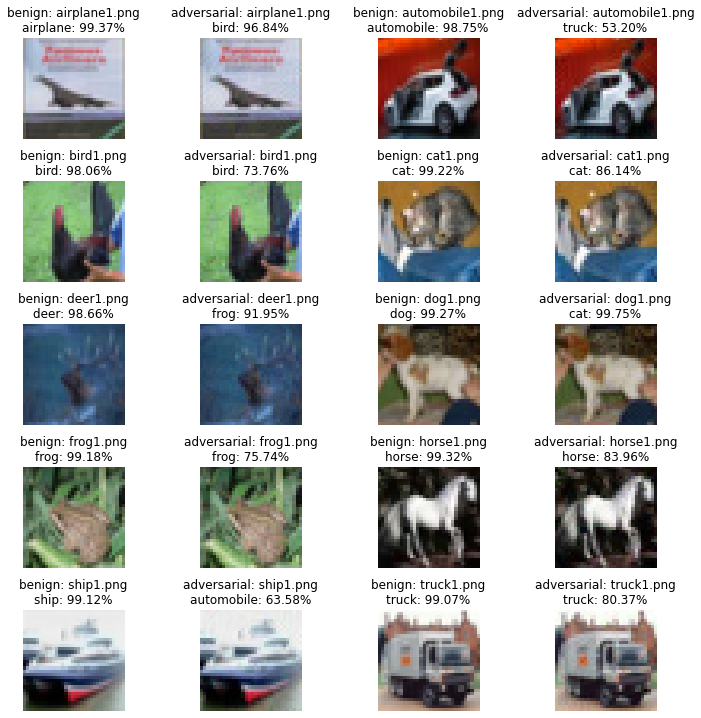

In [12]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# model = ptcv_get_model(model_list[1], pretrained=True).to(device)
plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./result/resnet20_cifar10/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()